In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic

import statsmodels.api as sm
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import os

In [2]:
# Code for regression part is modified from code from "universal functional regression with neural operator flows"
train_samples = 20000

n_x = 32
dims = [n_x, n_x]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#spath = Path('../trash/GP')
spath = Path('your_path/GRF_prior')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
torch.manual_seed(22) # fix the seed for reproducible regression result
modes = 16 # can be applied to 32x32, or 128x128
width = 128
mlp_width = 128

# GP hyperparameters
#kernel_length=0.1
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default


## Dataset parameters
length_scale_x = 0.4
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [3]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

/home/yshi5/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


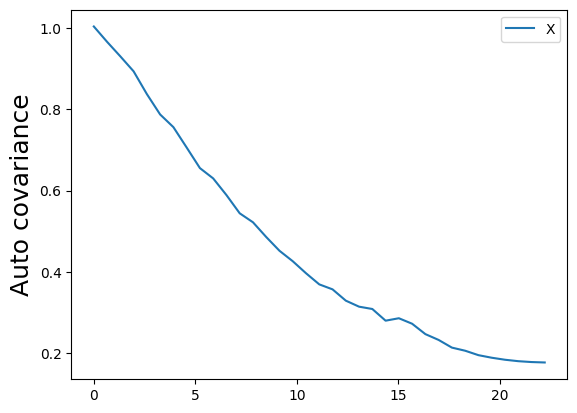

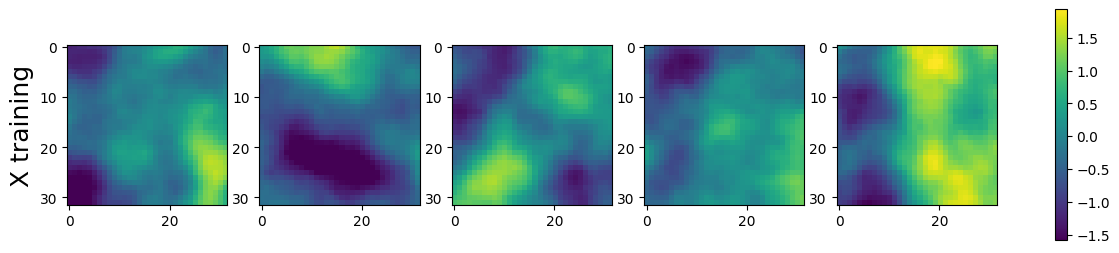

In [4]:
## Prepare training dataset

GP_2C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=dims)
x_test = GP_2C.sample_train_data(dims=dims, n_samples=train_samples)

loader_tr = DataLoader(x_test, batch_size=batch_size, shuffle=True)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_test[:, 0, :,:])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_test[i,0,:,:].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

## load trained model

In [5]:
spath

PosixPath('/net/ghisallo/scratch1/yshi5/OFM/GRF_prior')

In [7]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
 
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [38]:
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

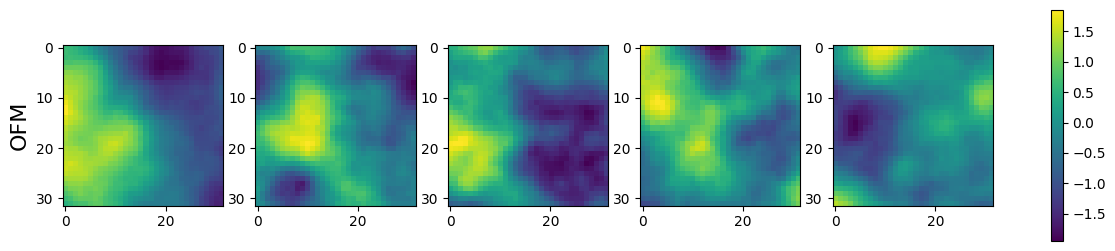

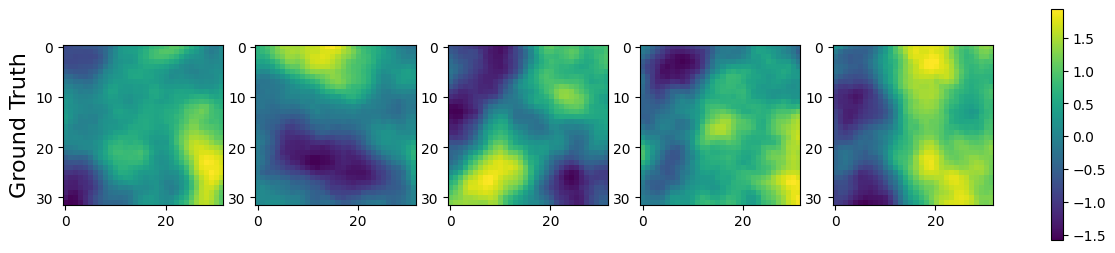

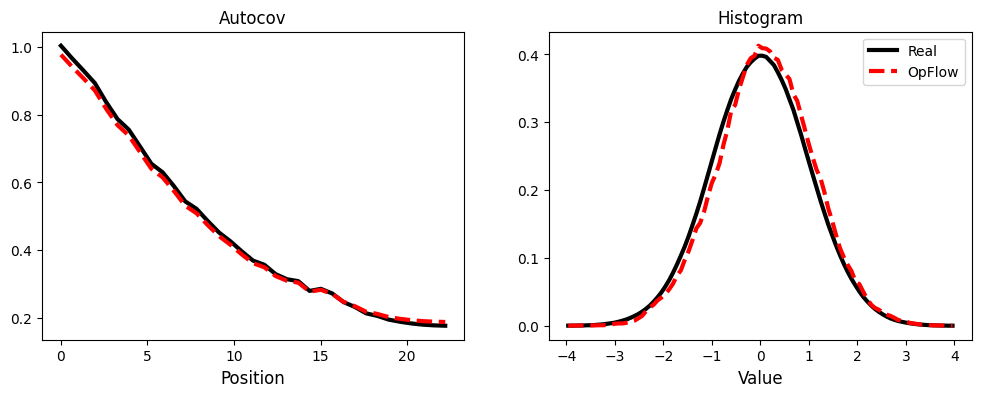

In [46]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_test[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(1):
        X_temp = fmot.sample([n_x, n_x], n_samples=400, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_test.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_test.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
    #plt.show()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)

    bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(bin_center, x_acovf_true, c='k', lw=3)
    ax[0].plot(bin_center, x_acovf, c='r',ls='--', lw=3)
    #ax[0].set_ylim(0.2, 0.45)
    ax[0].set_title('Autocov')
    ax[0].set_xlabel('Position', fontsize='large')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[1].set_title('Histogram')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Value', fontsize='large')
    #plt.savefig("plots/GP2GP/epoch_{}.pdf".format(epoch))

## 2D Regression

$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [10]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2

ndim = 32
lr = 1e-3 
epochs = 1000
noise_level = 0.01

# extract 32 random observations from a test sample
berno_mask = torch.zeros((ndim, ndim))

mask_idx = np.random.choice(ndim*ndim, 32,replace=False)
berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(ndim,ndim)
pos_mask = (berno_mask == 1)

# The ground truth that we used to extract random observation
u_obs_full = x_test[0:1,:]
u_obs_part = u_obs_full[:,:, pos_mask].to(device)

# generate noisy observation by injecting white noise
noise_pattern =  torch.randn_like(u_obs_part)
u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

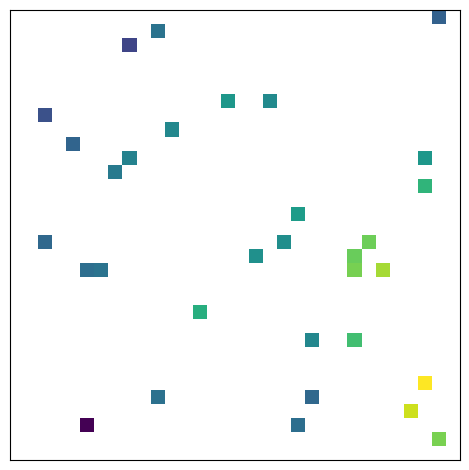

In [13]:
# for plotting the partial observation
add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern.detach().cpu()* np.sqrt(noise_level)).squeeze()

part_gt = u_obs_full.clone() + add_noise_plot
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)

plt.xticks([])
plt.yticks([])
#plt.title('Partial Observation', fontsize=16)
plt.tight_layout()

#plt.savefig('./demo_figure.png', transparent=True)
plt.show()

## MAP estimation (optional)

In [41]:
G = fmot

In [15]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,1, ndim, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=4, forward=True)
        
    def logp(self):
        # take more time to average out
        u, out_logp, prior_logp = self.G.data_likelihood_precise(self.a_target, n_eval=4, forward=True)

        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:, :, pos_mask])**2)/noise_level
        #loss2 = reg_opflow_a.logp()
        loss1 = -0.5*torch.sum((u_obs_part - cur_u[:, pos_mask])**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [16]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [ ]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

In [18]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [21]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


## comparion between ground-truth mean and MAP mean from OFM

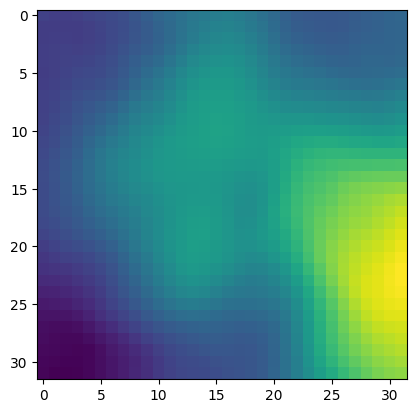

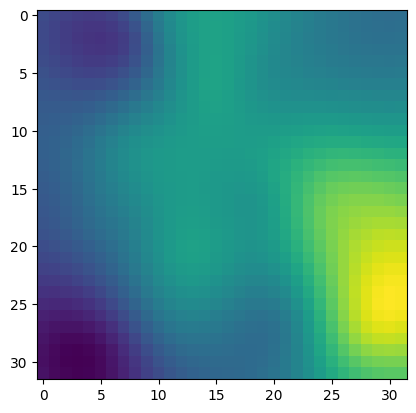

In [22]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
plt.imshow(u_opflow.clone().detach().cpu().squeeze())
plt.figure()
plt.imshow(y_mean)

## SGLD

In [35]:
"""
# for arius, memory constrain
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary()) 
"""


In [24]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_2481141/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [44]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise(a, n_eval=4, forward=True)
    loss1 = -0.5*torch.sum((u_obs_part - cur_u[:,  pos_mask])**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [26]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [48]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)


temperature = 1
momentum = 0

max_itr = int(2e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=1e-3,
                                     lr_final=8e-4,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )


hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [9:42:12<00:00,  1.75s/it]


In [49]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True).cpu().detach())
u_samples_all = torch.vstack(u_samples_all)

torch.Size([100, 1, 32, 32])


In [ ]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [69]:

## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:]


sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

## Final Plots

In [ ]:
opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

In [77]:
saved_folder = 'GRF2GRF_OFM'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")

In [20]:
from matplotlib.colors import TwoSlopeNorm

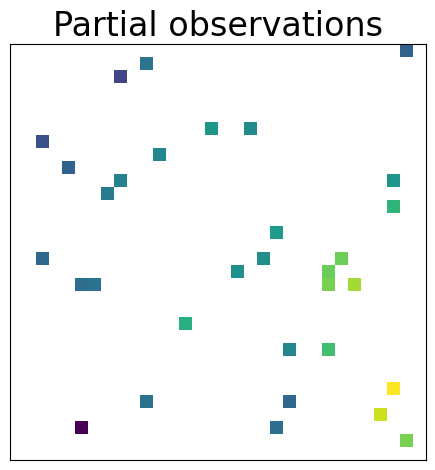

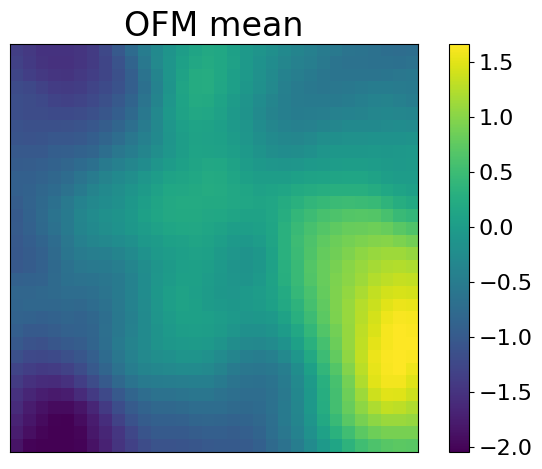

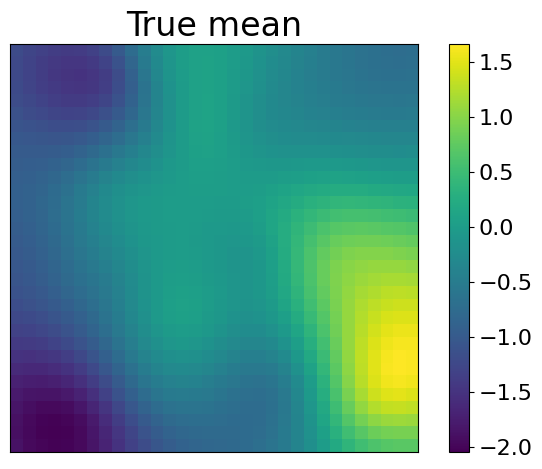

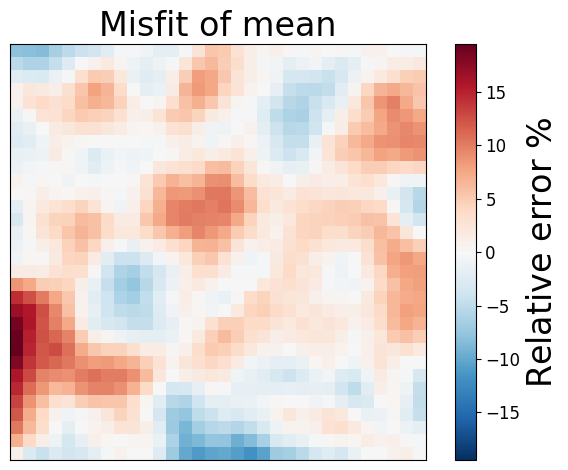

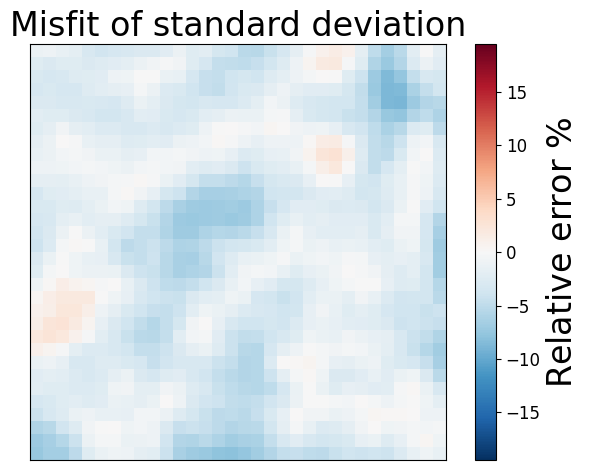

In [96]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
y_std = y_std.reshape(32,32)
y_samples = gpr_model_ground_truth.sample_y(X, 5000).reshape(32,32,-1)

### plot parameter
y_min_plot, y_max_plot = y_mean.min(), y_mean.max()
y_abs_max = np.abs(y_mean).max()

part_gt = u_obs_full.clone() + add_noise_plot
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial observations', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_partial_obs.pdf")
#plt.savefig(f"paper_pdf/{folder}/ex2_partial_obs.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_partial_obs.pdf")

plt.figure()
plt.imshow(sample_mean, vmin=y_min_plot, vmax=y_max_plot)
#plt.imshow(sample_mean)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('OFM mean', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_ofm_mean.pdf")
#plt.savefig(f"paper_pdf/{folder}/ex2_opflow_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_opflow_mean.pdf")

plt.figure()
plt.imshow(y_mean, vmin=y_min_plot, vmax=y_max_plot)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([])
plt.yticks([])
plt.title('True mean', fontsize=24)

plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_true_mean.pdf")
#plt.savefig(f"paper_pdf/{folder}/ex2_true_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_true_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
#norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
#plt.imshow(relative_error, norm=norm,cmap="RdBu_r")
plt.imshow(relative_error, norm=norm_1, cmap="RdBu_r")
#pc = plt.pcolormesh(x,y,z, norm=norm, cmap="RdBu_r")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Relative error $\%$", fontsize=24)
cbar.ax.tick_params(labelsize=12)
plt.xticks([])
plt.yticks([])
plt.title('Misfit of mean', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_misfit_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_misfit_mean.pdf")

plt.figure()
relative_error = (sample_std - y_std)/y_abs_max*100
#norm = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(relative_error, norm=norm_1, cmap="RdBu_r")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Relative error $\%$", fontsize=24)
cbar.ax.tick_params(labelsize=12)

plt.xticks([])
plt.yticks([])
plt.title('Misfit of standard deviation', fontsize=24)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_misfit_std.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_misfit_std.pdf")

## Generate 3 representative scenarios

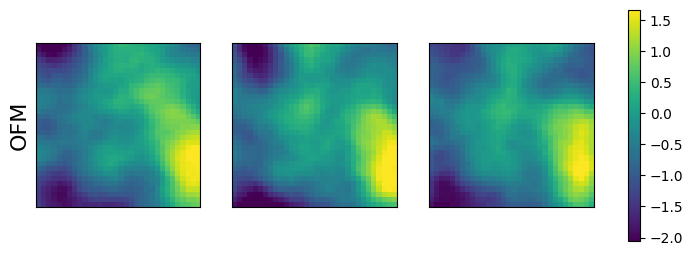

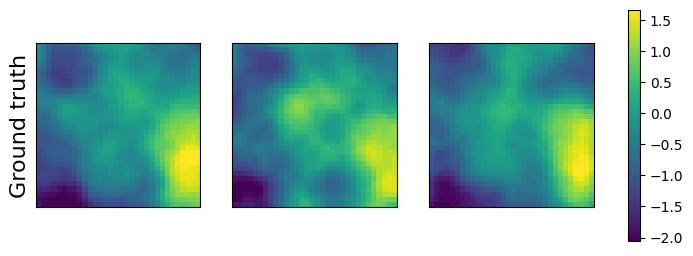

In [80]:
## each one generate 3 plots
## For the scenario, select 3 representative scenario for OpFlow and Ground Truth

#random_idx = np.array([280, 73, 401])
#random_idx_gt = np.array([25, 7,380])
random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow, vmin=y_min_plot, vmax=y_max_plot)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OFM', fontsize=16)
        
bar = ax[2].imshow(x_opflow, vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=ax)    
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_scen_ofm.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_scen_opflow.pdf")        
#bar = ax[2].imshow(x_opflow)
#fig.colorbar(bar, ax=ax)
#plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_scen_opflow.pdf")
        
random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example, vmin=y_min_plot, vmax=y_max_plot)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Ground truth', fontsize=16)
bar = ax[2].imshow(x_opflow, vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=ax)   
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_scen_gt.pdf")
#plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_scen_ground_truth.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_scen_gt.pdf")   

In [85]:
import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()